In [ ]:
# find the maximum radius of the star, then plot tconv and ebind
# basically smooths out this process into one notebook

In [1]:
import mesa_reader as mr
import matplotlib.pylab as plt
import numpy as np
from heapq import nlargest
import os
import math
from math import log
from scipy.integrate import cumtrapz

G = 6.67408e-11 # gravitational constant
# change G to cgs units
G = G * 1e3

# if the data is from the site, set this to False
# if the data is from us, set this to True
rLogForm = True

# adjust to change size of output graph
graphX = 15
graphY = 7

In [2]:
# bringing in the data

filenames = []

# find all the files in the directory called "history.data"
workingDirectory = '/Users/emilyflynn/Desktop/25M_tests/30M_logs'

for root, dirs, files in os.walk(workingDirectory):
    for file in files:
        if file.endswith("history.data"):
            filenames.append(os.path.join(root, file))

# for each file, go in and correct that quotation mark error
# replace 10.14-2019 with 10.14-2019"
for file in filenames:
    s = open(file).read()
    s = s.replace('10.14-2019 ', '10.14-2019"')
    f = open(file, 'w')
    f.write(s)
    f.close()

# for each file, read it into a variable based on which log folder it's in
hBRExists = False
hARExists, hRExists = False, False
htSBExists, htlgTExists = False, False
hCExists, hFExists, hLExists = False, False, False

for file in filenames:
    if 'before_remove' in file:
        hBR = mr.MesaData(file)
        hBRExists = True
        
    elif 'after_remove' in file:
        hAR = mr.MesaData(file)
        hARExists = True
        
    elif 'remove' in file:
        hR = mr.MesaData(file)
        hRExists = True
        
    elif 'to_si_burn' in file:
        htSB = mr.MesaData(file)
        htSBExists = True
        
    elif 'to_lgT_9.9' in file:
        htlgT = mr.MesaData(file)
        hlgTExists = True
        
    elif 'convert' in file:
        hC = mr.MesaData(file)
        hCExists = True
        
    elif 'finish' in file:
        hF = mr.MesaData(file)
        hFExists = True
        
    else:
        hL = mr.MesaData(file)
        hLExists = True
    
    


# frankenstein the data together because MESA is MESA

hModels = []
hRadius = []

if hBRExists:
    hRadius.append(hBR.log_R)
    hModels.append(hBR.model_number)

if hRExists:
    hRadius.append(hR.log_R)
    hModels.append(hR.model_number)

if hARExists:
    hRadius.append(hAR.log_R)
    hModels.append(hAR.model_number)

if htSBExists:
    hRadius.append(htSB.log_R)
    hModels.append(htSB.model_number)

if htlgTExists:
    hRadius.append(htlgT.log_R)
    hModels.append(htlgT.model_number)

if hCExists:
    hRadius.append(hC.log_R)
    hModels.append(hC.model_number)

# these are behaving weirdly
# if hFExists:
#     hRadius.append(hF.log_R)
#     hModels.append(hF.model_number)

if hLExists:
    hRadius.append(hL.log_R)
    hModels.append(hL.model_number)

In [3]:
# find the model number for when the radius is at its maximum
maxValues = []
maxModelNumbers = []

# find the biggest 5 in each history file
for x in range(len(hRadius)):
    data = hRadius[x]
    maxValues.append(nlargest(1, data))
    index = nlargest(1, range(len(data)), key=lambda idx: data[idx])
    maxModelNumbers.append(hModels[x][index])

print(maxValues)
print(maxModelNumbers)
print('-----')
print(max(maxValues))
modelNumber = int(maxModelNumbers[np.argmax(maxValues)])
print(modelNumber)





# import desired profile

# find all profile.index files
filenames = []

#workingDirectory = '/Users/emilyflynn/Desktop/25M_tests/70M_logs/'

for root, dirs, files in os.walk(workingDirectory):
    for file in files:
        if file.endswith("profiles.index"):
            filenames.append(os.path.join(root, file))

profiles = []
# import files
for file in filenames:
    i = mr.MesaProfileIndex(file)
    profiles.append(i)

# find the closest model number - ugly but functional
closest = 0
diff = 1e10
profilePath = ''
j = 0
for index in profiles:
    values = index.model_numbers
    profileNums = index.profile_numbers
    k=0
    for i in values:
        if (abs(modelNumber - i) < diff):
            diff = abs(modelNumber - i)
            closest = i
            og = filenames[j]
            og = og[:-14] # put together the file name given the directory
            profilePath = og + 'profile' + str(profileNums[k]) + '.data'
        k+=1
    j+=1

print('difference: ' + str(diff))
print('model number: ' + str(closest))
print('file path: ' + str(profilePath))

# import target profile
p = mr.MesaData(profilePath)

[[3.0274879200465348], [3.0254979131274795], [3.0214272785938334], [2.9663907771571107], [2.8907767330507257], [2.769246611634912]]
[array([294]), array([321]), array([324]), array([333]), array([1103]), array([54])]
-----
[3.0274879200465348]
294
difference: 6
model number: 300
file path: /Users/emilyflynn/Desktop/25M_tests/30M_logs/LOGS_before_remove/profile13.data


(1000000000.0, 100000000000000.0)

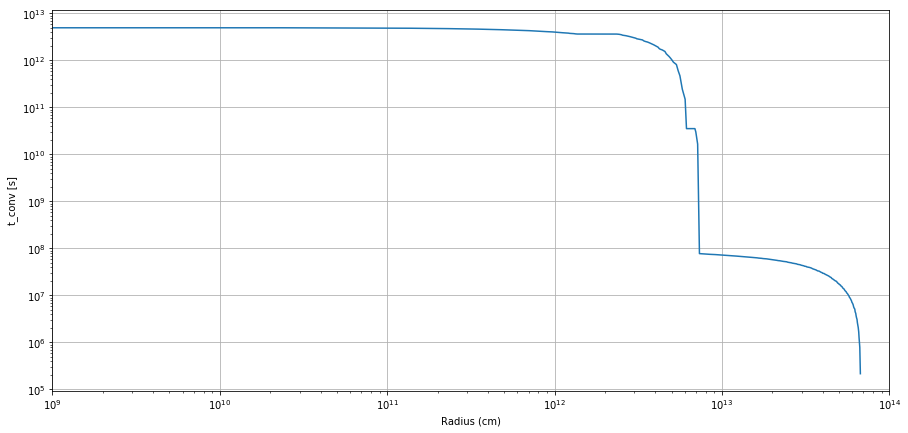

In [4]:
# plot tconv

# get radius
if rLogForm:
    r = p.logR
    r = 10**r 
else:
    r = p.radius

r = r*69.551e9   # change units to cm
r = r[100:]      # cut off the first 100 points - takes care of surface weirdness

v = p.log_conv_vel
v = [i if i>1e-8 else 1e-8 for i in v] # if having issues with v being too close to 0
v = np.power(10, v) # un-log it
v = -1/v            # it'll be integrated like this
v = v[100:]         # cut off first 100 points

# integrate
tconv = cumtrapz(y=v, x=r)

# plot
fig, ax = plt.subplots(figsize=(graphX,graphY))
plt.loglog(r[:-1], tconv)
plt.xlabel('Radius (cm)')
plt.ylabel('t_conv [s]')
plt.grid(True)

# may need to adjust limits to display full curve
# plt.ylim(1e4, 1e12)
plt.xlim(1e9, 1e14)

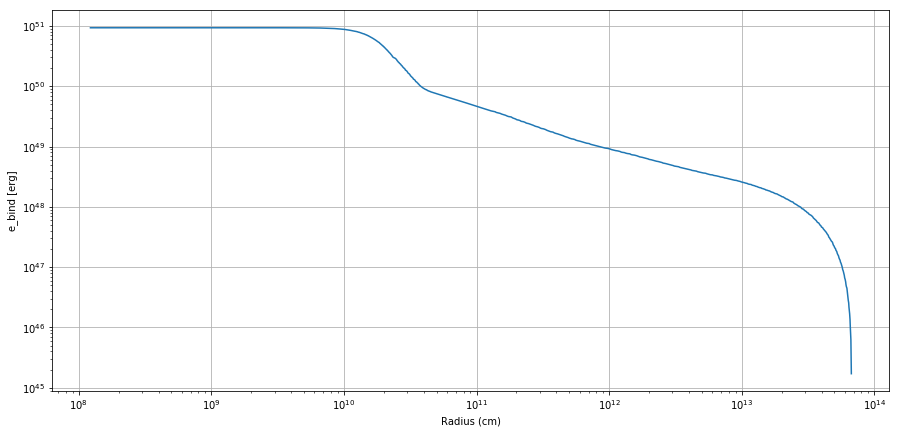

In [5]:
# find e_bind, energy needed to strip the envelope's mass to radius r - eq. 4

# get radius
if rLogForm:
    r = p.logR
    r = 10**r 
else:
    r = p.radius

r = r*69.551e9   # change units to cm
r = r[100:]      # cut off the first 100 points - takes care of surface weirdness

m = p.mass
m = m*1.989e33   # change units to grams
m = m[100:]      # exclude first 100 points

integrand = []

for i in range(len(m)):
    x = G * m[i] / r[i]
    integrand.append(x)

ebind = cumtrapz(y=integrand, x=m)

# plot
fig, ax = plt.subplots(figsize=(graphX,graphY))
plt.loglog(r[:-1], -ebind)
plt.xlabel('Radius (cm)')
plt.ylabel('e_bind [erg]')
plt.grid(True)

# can adjust if needed
# plt.xlim(1e9, 1e13)
# plt.ylim(1e44, 1e50)